<a href="https://colab.research.google.com/github/FabianaAndrade/projeto_IA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Aryane de Alcantara Chaves - 11893303
*   Fabiana Andrade Barroso - 13729431
*   Gabriel Kennuy de Assis Malta Peruso - 13673173
*   Ingrid Moreno da Silva - 13729070
*   Izabel Christine dos Santos Barranco  - 11847711
*   Jenifer Galvão de Morais - 11912147









In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **IMPORT DE BIBLIOTECAS**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## **LEITURA DE DADOS**

In [ ]:
# 1. Ler os dados dos arquivos
X_file = 'X.txt'
Y_file = 'Y_letra.txt' # pular linha no final do arquivo quando for subir

with open(X_file, 'r') as file:
    linhas_X = file.readlines()

with open(Y_file, 'r') as file:
    rotulos = file.readlines()

# 2. Codificação dos rótulos (Y_letra.txt)
classes = sorted(set(rotulos))  # Obter todas as classes únicas
num_classes = len(classes) # Usar este valor para o parametro de quantidade de neuronios de saida

rotulos_encoded = []
for rotulo in rotulos:
    index = classes.index(rotulo)  # Obter o índice da classe no vetor de classes
    one_hot = [0] * num_classes
    one_hot[index] = 1  # Definir o valor 1 para a classe correspondente
    rotulos_encoded.append(one_hot)

x = []
for linha in linhas_X:
    valores = linha.strip().split(',')
    valores_int = [int(valor) for valor in valores if valor.strip()]  # Remover valores vazios e espaços em branco
    if valores_int:
        x.append(valores_int)


x = np.array(x, dtype=int)  # Convertendo para int
y = np.array(rotulos_encoded)
tamanho_vetor = len(x[0]) # Usar esse valor para o parametro de quantidade de neuronios de entrada

print("x ", x[0])
print("y ", y[26])

x  [ 1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1
  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1
  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1
 -1 -1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1]
y  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## **ARQUITETURA**

In [ ]:
class MLP:
    # quantidade de neuronios de entrada = quantidade de valores do vetor/matriz do input
    # quantidade de neuronios da camada escondida = pode ser um parametro
    # quantidade de neuronios da camada de saida = quantidade de labels existentes do problema extraidas do arquivo y_letra
    def __init__(self, input_layer_size, hidden_layer_size, output_layer_size):
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size

        # Inicialização aleatória dos pesos e bias a partir de uma distribuição normal (gaussiana) com média 0 e desvio padrão 1.
        self.weights_input_hidden_layer = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.weights_hidden_output_layer = np.random.randn(self.hidden_layer_size, self.output_layer_size)

        # Inicialização dos bias
        self.bias_hidden_layer = np.random.randn(1, self.hidden_layer_size)
        self.bias_output_layer = np.random.randn(1, self.output_layer_size)

    def forward(self, initial_input):
        # Calculo do input da camada escondida
        # Calcula atraves da multiplicação do valores da camada de entrada com o pesos da camada de entrada para a camada escondida
        # e soma com os bias da camada de entrada para a camada escondida
        self.hidden_layer_input = np.dot(initial_input, self.weights_input_hidden_layer) + self.bias_hidden_layer
        # Calculo do output da camada escondida
        # Calcula atraves do resultado do input da camada escondida passando pela função sigmoide
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)

        # Calculo valores camada de saida, mesmo comportamento da camada escondida
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output_layer) + self.bias_output_layer
        self.output_layer_output = self.sigmoid(self.output_layer_input)

        return self.output_layer_output

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)


    # Funções para cross validation
    def compute_error(self, predicted_output, true_output):
        return np.mean(np.square(true_output - predicted_output))

    def train(self, x_train, y_train, x_val, y_val, learning_rate, max_epochs, patience):
        best_val_error = float('inf')
        epochs_without_improvement = 0
        best_weights = (self.weights_input_hidden_layer.copy(), self.weights_hidden_output_layer.copy(),
                        self.bias_hidden_layer.copy(), self.bias_output_layer.copy())

        for epoch in range(max_epochs):
            # Forward pass
            predictions = self.forward(x_train)
            error = self.compute_error(predictions, y_train)

            # Backward pass
            output_layer_error = y_train - predictions
            output_layer_delta = output_layer_error * self.sigmoid_derivative(predictions)

            hidden_layer_error = np.dot(output_layer_delta, self.weights_hidden_output_layer.T)
            hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)

            # Atualização dos pesos e bias
            self.weights_hidden_output_layer += np.dot(self.hidden_layer_output.T, output_layer_delta) * learning_rate
            self.bias_output_layer += np.sum(output_layer_delta, axis=0, keepdims=True) * learning_rate

            self.weights_input_hidden_layer += np.dot(x_train.T, hidden_layer_delta) * learning_rate
            self.bias_hidden_layer += np.sum(hidden_layer_delta, axis=0, keepdims=True) * learning_rate

            # Validar desempenho no conjunto de validação
            val_predictions = self.forward(x_val)
            val_error = self.compute_error(val_predictions, y_val)
            print(f'Epoch {epoch+1}/{max_epochs} - Training Error: {error:.4f} - Validation Error: {val_error:.4f}')

            # Verificação do Early Stopping
            if val_error < best_val_error:
                best_val_error = val_error
                epochs_without_improvement = 0
                best_weights = (self.weights_input_hidden_layer.copy(), self.weights_hidden_output_layer.copy(),
                                self.bias_hidden_layer.copy(), self.bias_output_layer.copy())
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

        # Restaurar os melhores pesos
        self.weights_input_hidden_layer, self.weights_hidden_output_layer, \
        self.bias_hidden_layer, self.bias_output_layer = best_weights

        return best_val_error


In [ ]:
# Define o diretório de output

output_dir = "output_files"
# Cria diretório de output
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Função criada para salvar os pesos iniciais no .txt

def save_initial_weights(initial_weights):
    # Define o caminho e o nome do arquivo de saída
    output_file = "initial_weights.txt"

    # Abre o arquivo para escrita
    with open(output_file, "w") as txt_file:
        # Escreve um cabeçalho indicando a origem dos pesos
        txt_file.write("Pesos Iniciais:\n\n")

        # Itera sobre cada camada de pesos
        for index, layer in enumerate(initial_weights):
            # Determina a origem da camada de pesos
            if index == 0:
                txt_file.write("Passagem da camada sensorial para a camada escondida\n\n")
            elif index == 1:
                txt_file.write("Passagem da camada escondida para a camada de saída\n\n")

            # Itera sobre os neurônios na camada
            for neuron_index, weights in enumerate(layer):
                # Escreve os pesos do neurônio
                txt_file.write("Neurônio: " + str(neuron_index + 1) + ":\n")
                for weight in weights:
                    txt_file.write(str(weight) + " ")
                txt_file.write("\n")

            # Adiciona uma linha em branco entre as camadas
            txt_file.write("\n")

In [ ]:
# Função criada para salvar os pesos finais no .txt

def save_final_weights(final_weights):
    # Define o caminho e o nome do arquivo de saída
    output_file = "final_weights.txt"

    # Abre o arquivo para escrita
    with open(output_file, "w") as txt_file:
        # Escreve um cabeçalho indicando a origem dos pesos
        txt_file.write("Pesos Finais:\n\n")

        # Itera sobre cada camada de pesos
        for index, layer in enumerate(final_weights):
            # Determina a origem da camada de pesos
            if index == 0:
                txt_file.write("Passagem da camada sensorial para a camada escondida\n\n")
            elif index == 1:
                txt_file.write("Passagem da camada escondida para a camada de saída\n\n")

            # Itera sobre os neurônios na camada
            for neuron_index, weights in enumerate(layer):
                # Escreve os pesos do neurônio
                txt_file.write("Neurônio: " + str(neuron_index + 1) + ":\n")
                for weight in weights:
                    txt_file.write(str(weight) + " ")
                txt_file.write("\n")

            # Adiciona uma linha em branco entre as camadas
            txt_file.write("\n")

In [ ]:
# Função criada para salvar os parametros no .txt

def save_architecture_parameters(learning_rate, stopping_criteria, input_neurons, hidden_neurons, output_neurons):
    # Define o caminho e o nome do arquivo de saída
    output_file = "architecture_parameters.txt"

    # Abre o arquivo para escrita
    with open(output_file, "w") as txt_ParametersFile:
        txt_ParametersFile.write("Taxa de aprendizado: " +
                        str(learning_rate) + "\n")
        txt_ParametersFile.write("Critério de parada: " +
                        str(stopping_criteria) + "\n")
        txt_ParametersFile.write("Nro de neurônios (camada de entrada): " +
                        str(input_neurons) + "\n")
        txt_ParametersFile.write("Nro de neurônios (camada oculta): " +
                        str(hidden_neurons) + "\n")
        txt_ParametersFile.write("Nro de neurônios (camada de saída): " +
                        str(output_neurons) + "\n")
    txt_ParametersFile.close()
    # Fecha o arquivo

In [ ]:
# Função criada para salvar os erros por epoca no .txt

def save_error_by_epoch(error, epoch):
    # Define o caminho e o nome do arquivo de saída
    output_file = "error_by_epoch.txt"

    # Abre o arquivo para escrita
    with open(output_file, "a") as txt_file:
        # Escreve a média de erro da época
        txt_file.write("Média de erro da época " + str(epoch) + ": " +
                        str(error) + "\n")

    # Não é preciso fechar pois estamos usando appende ao inves de write

## **TESTES**

*   HOLD OUT S PARADA - ARY
*   HOLD OUT C PARADA - INGRID
*   CROSS VALIDATION S PARADA - JE
---



## **CROSS-VALIDATION DE PARADA**

In [ ]:
# Leitura e pré-processamento dos dados
X_file = 'X.txt'
Y_file = 'Y_letra.txt'
with open(X_file, 'r') as file:
    linhas_X = file.readlines()
with open(Y_file, 'r') as file:
    rotulos = file.readlines()

classes = sorted(set(rotulos))
num_classes = len(classes)

rotulos_encoded = []
for rotulo in rotulos:
    index = classes.index(rotulo)
    one_hot = [0] * num_classes
    one_hot[index] = 1
    rotulos_encoded.append(one_hot)

x = []
for linha in linhas_X:
    valores = linha.strip().split(',')
    valores_int = [int(valor) for valor in valores if valor.strip()]
    if valores_int:
        x.append(valores_int)

x = np.array(x, dtype=int)
y = np.array(rotulos_encoded)
tamanho_vetor = len(x[0])

# Divisão dos dados em treino e validação
train_size = int(0.8 * len(x))
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Definição da arquitetura da MLP
input_neurons = tamanho_vetor
hidden_neurons = 10  # Número de neurônios na camada oculta, pode ser ajustado
output_neurons = num_classes

# Criação da MLP
mlp = MLP(input_neurons, hidden_neurons, output_neurons)

# Salvar pesos iniciais
initial_weights = [mlp.weights_input_hidden_layer, mlp.weights_hidden_output_layer]
save_initial_weights(initial_weights)

# Treinamento com Early Stopping
learning_rate = 0.01
max_epochs = 1000
patience = 10

best_val_error = mlp.train(x_train, y_train, x_val, y_val, learning_rate, max_epochs, patience)

# Salvar pesos finais
final_weights = [mlp.weights_input_hidden_layer, mlp.weights_hidden_output_layer]
save_final_weights(final_weights)

# Salvar parâmetros da arquitetura
save_architecture_parameters(learning_rate, patience, input_neurons, hidden_neurons, output_neurons)

print("Treinamento concluído com erro de validação:", best_val_error)


Epoch 1/1000 - Training Error: 0.3950 - Validation Error: 0.1078
Epoch 2/1000 - Training Error: 0.1087 - Validation Error: 0.0415
Epoch 3/1000 - Training Error: 0.0420 - Validation Error: 0.0389
Epoch 4/1000 - Training Error: 0.0392 - Validation Error: 0.0381
Epoch 5/1000 - Training Error: 0.0382 - Validation Error: 0.0377
Epoch 6/1000 - Training Error: 0.0377 - Validation Error: 0.0374
Epoch 7/1000 - Training Error: 0.0374 - Validation Error: 0.0373
Epoch 8/1000 - Training Error: 0.0371 - Validation Error: 0.0371
Epoch 9/1000 - Training Error: 0.0369 - Validation Error: 0.0370
Epoch 10/1000 - Training Error: 0.0368 - Validation Error: 0.0369
Epoch 11/1000 - Training Error: 0.0367 - Validation Error: 0.0369
Epoch 12/1000 - Training Error: 0.0366 - Validation Error: 0.0368
Epoch 13/1000 - Training Error: 0.0365 - Validation Error: 0.0367
Epoch 14/1000 - Training Error: 0.0365 - Validation Error: 0.0367
Epoch 15/1000 - Training Error: 0.0364 - Validation Error: 0.0366
Epoch 16/1000 - Tra

## **SAÍDA**

[Text(0.5, 0, 'Labels Previstos'),
 Text(0, 0.5, 'Labels Verdadeiros'),
 Text(0.5, 1.0, 'Matriz de Confusão')]

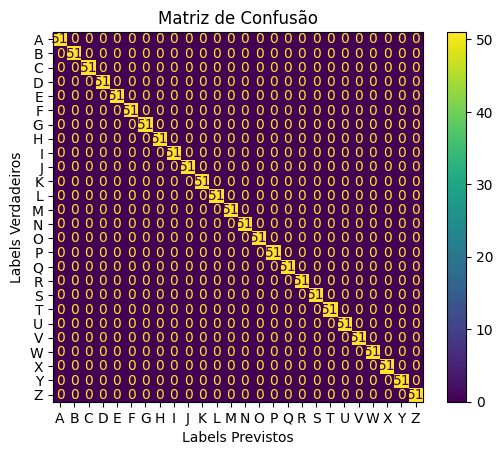

In [ ]:
# Labels verdardeiros
y_true = []
with open('/content/Y_letra.txt', 'r') as file:
    for line in file:
        y_true.append(line.strip())

# Labels previstos pelo modelo
y_pred = []
with open('/content/Y_letra.txt', 'r') as file:
    for line in file:
        y_pred.append(line.strip())

# Gera a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

#Plota matriz de confusão
cmd = ConfusionMatrixDisplay(cm, display_labels=['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
cmd.plot()
cmd.ax_.set(xlabel = 'Labels Previstos', ylabel = 'Labels Verdadeiros', title = 'Matriz de Confusão')